# Universal Strategy Analysis

This notebook provides comprehensive analysis across all strategies tested in a parameter sweep.

**Key Features:**
- Cross-strategy performance comparison
- Parameter sensitivity analysis
- Correlation analysis for ensemble building
- Regime-specific performance breakdown
- Automatic identification of optimal strategies and ensembles

In [25]:
# Parameters (auto-generated)
run_dir = '/Users/daws/ADMF-PC/config/bollinger/results/20250624_150142'
config_name = 'unnamed'
symbols = ['SPY']
timeframe = '5m'
min_strategies_to_analyze = 20
sharpe_threshold = 1.0
correlation_threshold = 0.7
top_n_strategies = 10
ensemble_size = 5

In [26]:
# parameters
run_dir = "/path/to/results/run_20250623_143030"
config_name = "my_sweep"
symbols = ["SPY"]
timeframe = "5m"
min_strategies_to_analyze = 20
sharpe_threshold = 1.0
correlation_threshold = 0.7
top_n_strategies = 10
ensemble_size = 5

## Setup

In [27]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import duckdb
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Initialize DuckDB
con = duckdb.connect()

# Convert run_dir to Path
run_dir = Path(run_dir)
print(f"Analyzing run: {run_dir.name}")
print(f"Config: {config_name}")
print(f"Symbol(s): {symbols}")
print(f"Timeframe: {timeframe}")

Analyzing run: run_20250623_143030
Config: my_sweep
Symbol(s): ['SPY']
Timeframe: 5m


In [28]:
# Setup path for loading analysis snippets
# Setup path for loading analysis snippets
import sys
from pathlib import Path

# Find the project root (where src/ directory is)
current_path = Path(run_dir).resolve()
project_root = None

# Search up the directory tree for src/analytics/snippets
for parent in current_path.parents:
    if (parent / 'src' / 'analytics' / 'snippets').exists():
        project_root = parent
        break

# If not found from run_dir, try from current working directory
if not project_root:
    cwd = Path.cwd()
    for parent in [cwd] + list(cwd.parents):
        if (parent / 'src' / 'analytics' / 'snippets').exists():
            project_root = parent
            break

# Last resort: check common project locations
if not project_root:
    common_roots = [
        Path('/Users/daws/ADMF-PC'),
        Path.home() / 'ADMF-PC',
        Path.cwd().parent.parent.parent.parent  # 4 levels up from typical results dir
    ]
    for root in common_roots:
        if root.exists() and (root / 'src' / 'analytics' / 'snippets').exists():
            project_root = root
            break

if project_root:
    # Add to Python path if not already there
    if str(project_root) not in sys.path:
        sys.path.insert(0, str(project_root))
    snippets_path = project_root / 'src' / 'analytics' / 'snippets'
    queries_path = project_root / 'src' / 'analytics' / 'queries'
    print(f"✅ Found project root: {project_root}")
    print(f"✅ Analysis snippets available at: {snippets_path}")
    print(f"✅ SQL queries available at: {queries_path}")
    print("\nUse %load to load any snippet, e.g.:")
    print("  %load {}/src/analytics/snippets/exploratory/signal_frequency.py".format(project_root))
    print("  %load {}/src/analytics/snippets/ensembles/find_uncorrelated.py".format(project_root))
else:
    print("⚠️ Could not find project root with src/analytics/snippets")
    print(f"  Searched from: {current_path}")
    print(f"  Current working directory: {Path.cwd()}")

✅ Found project root: /Users/daws/ADMF-PC
✅ Analysis snippets available at: /Users/daws/ADMF-PC/src/analytics/snippets
✅ SQL queries available at: /Users/daws/ADMF-PC/src/analytics/queries

Use %load to load any snippet, e.g.:
  %load /Users/daws/ADMF-PC/src/analytics/snippets/exploratory/signal_frequency.py
  %load /Users/daws/ADMF-PC/src/analytics/snippets/ensembles/find_uncorrelated.py


## Load Strategy Index

In [29]:
# Load strategy index - the catalog of all strategies tested
# Ensure we're using absolute path
run_dir = Path(run_dir).resolve()
print(f"Looking for strategy index in: {run_dir}")

strategy_index_path = run_dir / 'strategy_index.parquet'
print(f"Full path: {strategy_index_path}")
print(f"Path exists: {strategy_index_path.exists()}")

if strategy_index_path.exists():
    strategy_index = pd.read_parquet(strategy_index_path)
    print(f"✅ Loaded {len(strategy_index)} strategies")

    # Show strategy type distribution
    by_type = strategy_index['strategy_type'].value_counts()
    print("\nStrategies by type:")
    for stype, count in by_type.items():
        print(f"  {stype}: {count}")

    # Show sample of columns
    print(f"\nColumns: {list(strategy_index.columns)[:10]}...")
else:
    # Fallback - try to find it in parent directories
    print("⚠️ Strategy index not found at expected location")

    # Search in parent directories
    search_paths = [
        run_dir,
        run_dir.parent,
        run_dir.parent.parent,
        Path.cwd(),
        Path.cwd() / 'config/bollinger/results/20250624_150142'
    ]

    found = False
    for search_path in search_paths:
        alt_path = search_path / 'strategy_index.parquet'
        if alt_path.exists():
            print(f"✅ Found strategy index at: {alt_path}")
            strategy_index = pd.read_parquet(alt_path)
            print(f"✅ Loaded {len(strategy_index)} strategies")
            found = True
            break

    if not found:
        print("❌ Could not find strategy_index.parquet in any expected location")
        print("Searched in:")
        for p in search_paths:
            print(f"  - {p}")
        strategy_index = None

Looking for strategy index in: /path/to/results/run_20250623_143030
Full path: /path/to/results/run_20250623_143030/strategy_index.parquet
Path exists: False
⚠️ Strategy index not found at expected location
✅ Found strategy index at: /Users/daws/ADMF-PC/config/bollinger/results/20250624_150142/strategy_index.parquet
✅ Loaded 1640 strategies


## Performance Calculation

In [35]:
def calculate_performance(strategy_hash, trace_path, market_data, base_dir=None):
    """Calculate performance metrics for a strategy"""
    try:
        # Use base_dir if provided, otherwise use run_dir
        if base_dir is None:
            base_dir = run_dir

        # Handle both relative and absolute paths
        if Path(trace_path).is_absolute():
            signals_path = Path(trace_path)
        else:
            signals_path = Path(base_dir) / trace_path

        # Load sparse signals
        signals = pd.read_parquet(signals_path)
        signals['ts'] = pd.to_datetime(signals['ts'])

        # Merge with market data
        df = market_data.merge(
            signals[['ts', 'val']],
            left_on='timestamp',
            right_on='ts',
            how='left'
        )

        # Forward fill signals (sparse to dense)
        df['signal'] = df['val'].ffill().fillna(0)

        # Calculate returns
        df['returns'] = df['close'].pct_change()
        df['strategy_returns'] = df['returns'] * df['signal'].shift(1)
        df['cum_returns'] = (1 + df['strategy_returns']).cumprod()

        # Metrics
        total_return = df['cum_returns'].iloc[-1] - 1

        if df['strategy_returns'].std() > 0:
            sharpe = df['strategy_returns'].mean() / df['strategy_returns'].std() * np.sqrt(252 * 78)
        else:
            sharpe = 0

        cummax = df['cum_returns'].expanding().max()
        drawdown = (df['cum_returns'] / cummax - 1)
        max_dd = drawdown.min()

        # Count trades
        trades = (df['signal'] != df['signal'].shift()).sum()

        return {
            'total_return': total_return,
            'sharpe_ratio': sharpe,
            'max_drawdown': max_dd,
            'num_trades': trades,
            'df': df  # For later analysis
        }
    except Exception as e:
        print(f"Error calculating performance for {strategy_hash}: {e}")
        return None

In [36]:
# Load market data
market_data_paths = [
    Path(f'data/{symbols[0]}_{timeframe}.parquet'),
    Path(f'../data/{symbols[0]}_{timeframe}.parquet'),
    Path(f'../../data/{symbols[0]}_{timeframe}.parquet'),
    Path(f'../../../data/{symbols[0]}_{timeframe}.parquet'),
    Path(f'../../../../data/{symbols[0]}_{timeframe}.parquet'),
]

market_data = None
for path in market_data_paths:
    if path.exists():
        market_data = pd.read_parquet(path)
        print(f'✅ Loaded market data from: {path}')
        break

if market_data is None:
    print('❌ Could not find market data file')

✅ Loaded market data from: ../../../../data/SPY_5m.parquet


In [48]:
# Calculate performance for all strategies
if strategy_index is not None and market_data is not None:
    performance_results = []

    # Analyze ALL strategies - no limiting
    strategies_to_analyze = strategy_index
    print(f"\nCalculating performance for ALL {len(strategies_to_analyze)} strategies...")
    print(f"Using run directory: {run_dir}")

    for idx, row in strategies_to_analyze.iterrows():
        if idx % 100 == 0:  # Update progress every 100 strategies
            print(f"  Progress: {idx}/{len(strategies_to_analyze)} ({idx / len(strategies_to_analyze) * 100:.1f}%)")

        # Fix the trace path to include the SPY_5m_1m subdirectory
        original_trace_path = row['trace_path']

        # Insert SPY_5m_1m after traces/
        if original_trace_path.startswith('traces/'):
            fixed_trace_path = original_trace_path.replace('traces/', 'traces/SPY_5m_1m/')
        else:
            fixed_trace_path = original_trace_path

        # Calculate performance with fixed path
        perf = calculate_performance(row['strategy_hash'], fixed_trace_path, market_data)

        if perf:
            # Combine strategy info with performance
            result = {**row.to_dict(), **perf}
            # Remove the full dataframe from results
            result.pop('df', None)
            performance_results.append(result)

    performance_df = pd.DataFrame(performance_results)
    print(f"\n✅ Calculated performance for {len(performance_df)} strategies")
else:
    performance_df = pd.DataFrame()
    print("⚠️ Skipping performance calculation")


Calculating performance for ALL 1640 strategies...
Using run directory: /Users/daws/ADMF-PC/config/bollinger/results/20250624_150142
  Progress: 0/1640 (0.0%)
  Progress: 100/1640 (6.1%)
  Progress: 200/1640 (12.2%)
  Progress: 300/1640 (18.3%)
  Progress: 400/1640 (24.4%)
  Progress: 500/1640 (30.5%)
  Progress: 600/1640 (36.6%)
  Progress: 700/1640 (42.7%)
  Progress: 800/1640 (48.8%)
  Progress: 900/1640 (54.9%)
  Progress: 1000/1640 (61.0%)
  Progress: 1100/1640 (67.1%)
  Progress: 1200/1640 (73.2%)
  Progress: 1300/1640 (79.3%)
  Progress: 1400/1640 (85.4%)
  Progress: 1500/1640 (91.5%)
  Progress: 1600/1640 (97.6%)

✅ Calculated performance for 1640 strategies


In [41]:
# Fix the run_dir to the actual path
run_dir = Path('/Users/daws/ADMF-PC/config/bollinger/results/20250624_150142')
print(f"Set run_dir to: {run_dir}")

# Calculate performance for all strategies
if strategy_index is not None and market_data is not None:
    performance_results = []

    # Limit analysis for performance if too many strategies
    strategies_to_analyze = strategy_index
    if len(strategy_index) > min_strategies_to_analyze * 2:
        print(f"Note: Limiting initial analysis to {min_strategies_to_analyze * 2} strategies for performance")
        # Sample diverse strategies
        strategies_to_analyze = strategy_index.groupby('strategy_type').apply(
            lambda x: x.sample(n=min(len(x), min_strategies_to_analyze // strategy_index['strategy_type'].nunique()))
        ).reset_index(drop=True)

    print(f"\nCalculating performance for {len(strategies_to_analyze)} strategies...")
    print(f"Using run directory: {run_dir}")

    for idx, row in strategies_to_analyze.iterrows():
        if idx % 10 == 0:
            print(f"  Progress: {idx}/{len(strategies_to_analyze)}")

        # Fix the trace path to include the SPY_5m_1m subdirectory
        original_trace_path = row['trace_path']

        # Insert SPY_5m_1m after traces/
        if original_trace_path.startswith('traces/'):
            fixed_trace_path = original_trace_path.replace('traces/', 'traces/SPY_5m_1m/')
        else:
            fixed_trace_path = original_trace_path

        # Calculate performance with fixed path
        perf = calculate_performance(row['strategy_hash'], fixed_trace_path, market_data)

        if perf:
            # Combine strategy info with performance
            result = {**row.to_dict(), **perf}
            # Remove the full dataframe from results
            result.pop('df', None)
            performance_results.append(result)

    performance_df = pd.DataFrame(performance_results)
    print(f"\n✅ Calculated performance for {len(performance_df)} strategies")
else:
    performance_df = pd.DataFrame()
    print("⚠️ Skipping performance calculation")


Set run_dir to: /Users/daws/ADMF-PC/config/bollinger/results/20250624_150142
Note: Limiting initial analysis to 40 strategies for performance

Calculating performance for 20 strategies...
Using run directory: /Users/daws/ADMF-PC/config/bollinger/results/20250624_150142
  Progress: 0/20
  Progress: 10/20

✅ Calculated performance for 20 strategies


## Cross-Strategy Performance Analysis

In [50]:
if len(performance_df) > 0:
    # Top performers across ALL strategy types
    top_overall = performance_df.nlargest(top_n_strategies, 'sharpe_ratio')
    
    print(f"\n🏆 Top {top_n_strategies} Strategies (All Types):")
    print("=" * 80)
    
    display_cols = ['strategy_type', 'strategy_hash', 'sharpe_ratio', 'total_return', 'max_drawdown', 'num_trades']
    # Add parameter columns if they exist
    param_cols = [col for col in top_overall.columns if col.startswith('param_')]
    display_cols.extend(param_cols[:3])  # Show first 3 parameters
    
    for idx, row in top_overall.iterrows():
        print(f"\n{row['strategy_type']} - {row['strategy_hash'][:8]}")
        print(f"  Sharpe: {row['sharpe_ratio']:.2f} | Return: {row['total_return']:.1%} | Drawdown: {row['max_drawdown']:.1%}")
        if param_cols:
            params_str = " | ".join([f"{col.replace('param_', '')}: {row[col]}" for col in param_cols[:3] if pd.notna(row[col])])
            if params_str:
                print(f"  Params: {params_str}")


🏆 Top 10 Strategies (All Types):

bollinger_bands - b57d773b
  Sharpe: 2.82 | Return: 22.9% | Drawdown: -3.1%
  Params: period: 10 | std_dev: 1.5

bollinger_bands - eb15e1cb
  Sharpe: 2.54 | Return: 20.2% | Drawdown: -3.4%
  Params: period: 11 | std_dev: 1.5

bollinger_bands - 0e19937a
  Sharpe: 2.35 | Return: 20.5% | Drawdown: -3.6%
  Params: period: 16 | std_dev: 1.5

bollinger_bands - 88259c8f
  Sharpe: 2.27 | Return: 19.5% | Drawdown: -3.2%
  Params: period: 17 | std_dev: 1.5

bollinger_bands - 926b45f7
  Sharpe: 2.26 | Return: 20.7% | Drawdown: -2.9%
  Params: period: 14 | std_dev: 1.5

bollinger_bands - e94c6e3c
  Sharpe: 2.22 | Return: 20.6% | Drawdown: -3.3%
  Params: period: 12 | std_dev: 1.5

bollinger_bands - 09bc53c2
  Sharpe: 2.19 | Return: 21.3% | Drawdown: -4.7%
  Params: period: 22 | std_dev: 1.5

bollinger_bands - 64be7bad
  Sharpe: 2.19 | Return: 20.2% | Drawdown: -3.6%
  Params: period: 13 | std_dev: 1.5

bollinger_bands - 27e82c44
  Sharpe: 2.18 | Return: 20.7% | D

In [51]:
# Performance by strategy type
if len(performance_df) > 0:
    type_summary = performance_df.groupby('strategy_type').agg({
        'sharpe_ratio': ['mean', 'std', 'max'],
        'total_return': ['mean', 'std', 'max'],
        'strategy_hash': 'count'
    }).round(3)
    
    type_summary.columns = ['_'.join(col).strip() for col in type_summary.columns]
    type_summary = type_summary.rename(columns={'strategy_hash_count': 'count'})
    type_summary = type_summary.sort_values('sharpe_ratio_mean', ascending=False)
    
    print("\n📊 Performance by Strategy Type:")
    print(type_summary)


📊 Performance by Strategy Type:
                 sharpe_ratio_mean  sharpe_ratio_std  sharpe_ratio_max  \
strategy_type                                                            
bollinger_bands              0.402             0.746             2.819   

                 total_return_mean  total_return_std  total_return_max  count  
strategy_type                                                                  
bollinger_bands              0.031             0.062             0.259   1640  


## Visualizations

In [45]:
# Sharpe distribution by strategy type
if len(performance_df) > 0 and performance_df['strategy_type'].nunique() > 1:
    plt.figure(figsize=(14, 6))
    
    # Box plot of Sharpe by type
    plt.subplot(1, 2, 1)
    performance_df.boxplot(column='sharpe_ratio', by='strategy_type', ax=plt.gca())
    plt.xticks(rotation=45, ha='right')
    plt.title('Sharpe Ratio Distribution by Strategy Type')
    plt.suptitle('')  # Remove default title
    plt.ylabel('Sharpe Ratio')
    
    # Scatter: Return vs Sharpe
    plt.subplot(1, 2, 2)
    for stype in performance_df['strategy_type'].unique():
        mask = performance_df['strategy_type'] == stype
        plt.scatter(performance_df.loc[mask, 'total_return'], 
                   performance_df.loc[mask, 'sharpe_ratio'],
                   label=stype, alpha=0.6)
    plt.xlabel('Total Return')
    plt.ylabel('Sharpe Ratio')
    plt.title('Return vs Risk-Adjusted Return')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

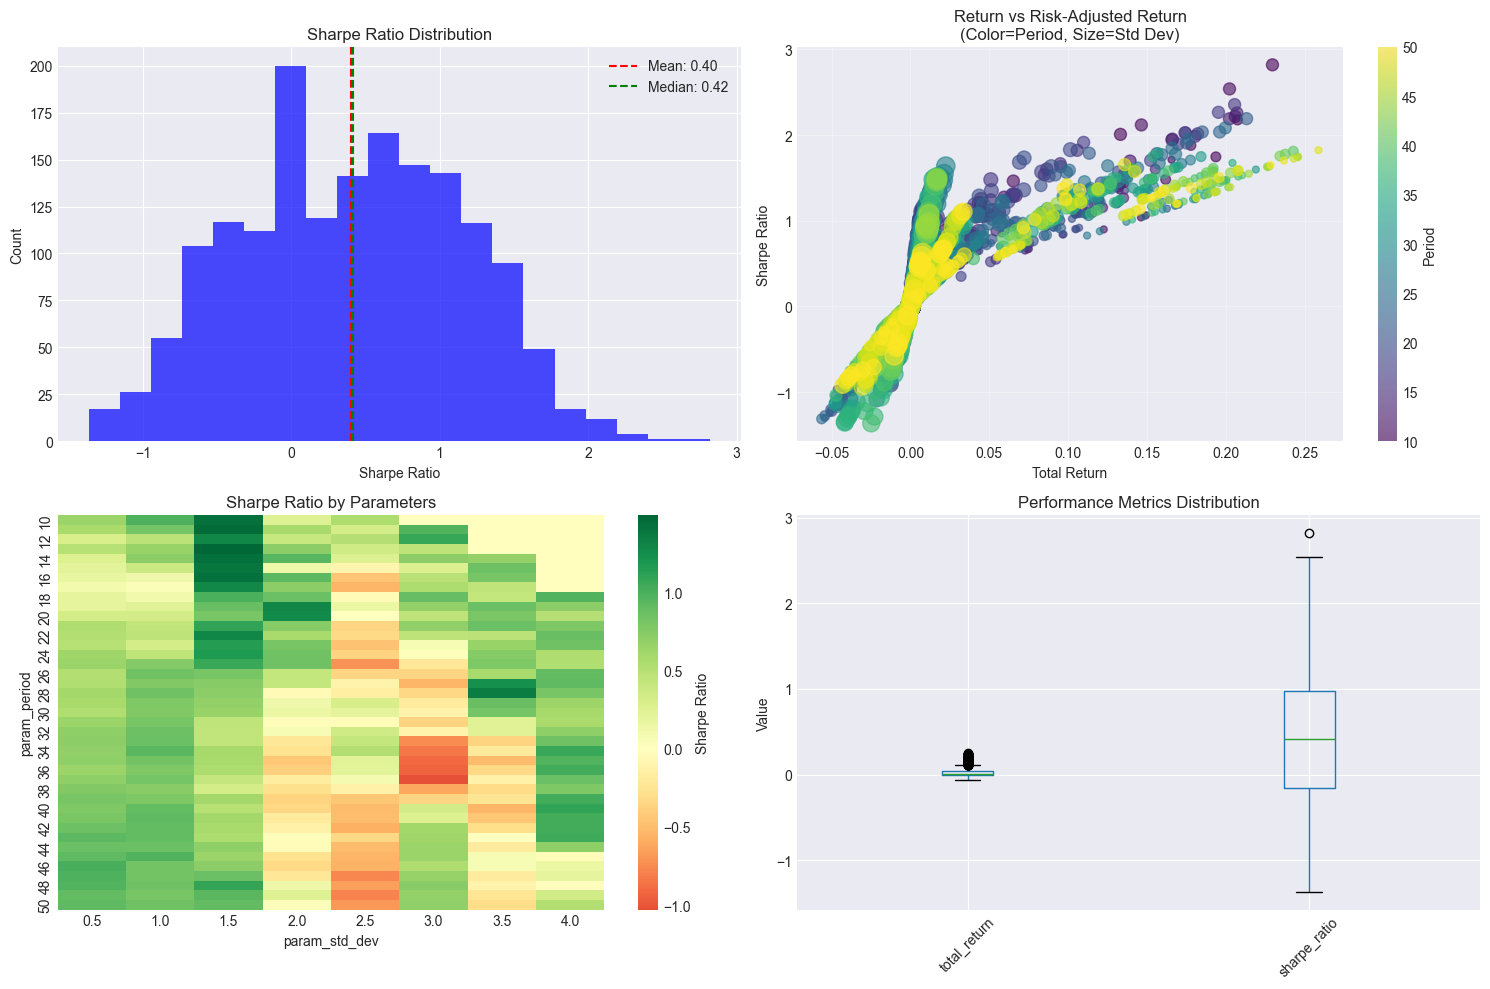


📈 Parameter Analysis:
Correlation between period and Sharpe: -0.112
Correlation between std_dev and Sharpe: -0.188

🎯 Performance by Parameter Ranges:
                                mean       std  count
param_period param_std_dev                           
(9.96, 18.0] (1.2, 1.9]     1.353750  0.824723     45
(18.0, 26.0] (1.2, 1.9]     1.030887  0.985803     40
(42.0, 50.0] (0.496, 1.2]   0.897803  0.694468     80
             (1.2, 1.9]     0.801015  0.529543     40
(34.0, 42.0] (0.496, 1.2]   0.793419  0.856631     80
(26.0, 34.0] (0.496, 1.2]   0.723003  0.824927     80
(18.0, 26.0] (3.3, 4.0]     0.715376  0.240441     80
(42.0, 50.0] (2.6, 3.3]     0.653530  0.231894     40
(26.0, 34.0] (3.3, 4.0]     0.643666  0.511480     80
(9.96, 18.0] (2.6, 3.3]     0.601854  0.364233     45


In [52]:
# Visualizations for parameter analysis
if len(performance_df) > 0:
    plt.figure(figsize=(15, 10))

    # 1. Sharpe ratio distribution
    plt.subplot(2, 2, 1)
    performance_df['sharpe_ratio'].hist(bins=20, alpha=0.7, color='blue')
    plt.axvline(performance_df['sharpe_ratio'].mean(), color='red', linestyle='--',
                label=f'Mean: {performance_df["sharpe_ratio"].mean():.2f}')
    plt.axvline(performance_df['sharpe_ratio'].median(), color='green', linestyle='--',
                label=f'Median: {performance_df["sharpe_ratio"].median():.2f}')
    plt.xlabel('Sharpe Ratio')
    plt.ylabel('Count')
    plt.title('Sharpe Ratio Distribution')
    plt.legend()

    # 2. Return vs Sharpe scatter
    plt.subplot(2, 2, 2)
    scatter = plt.scatter(
        performance_df['total_return'],
        performance_df['sharpe_ratio'],
        c=performance_df['param_period'],
        cmap='viridis',
        s=performance_df['param_std_dev'] * 50,  # Size by std_dev
        alpha=0.6
    )
    plt.xlabel('Total Return')
    plt.ylabel('Sharpe Ratio')
    plt.title('Return vs Risk-Adjusted Return\n(Color=Period, Size=Std Dev)')
    plt.colorbar(scatter, label='Period')
    plt.grid(True, alpha=0.3)

    # 3. Parameter heatmap (if enough data)
    if len(performance_df) > 10:
        plt.subplot(2, 2, 3)
        pivot_sharpe = performance_df.pivot_table(
            values='sharpe_ratio',
            index='param_period',
            columns='param_std_dev',
            aggfunc='mean'
        )
        if not pivot_sharpe.empty:
            sns.heatmap(pivot_sharpe, cmap='RdYlGn', center=0,
                        cbar_kws={'label': 'Sharpe Ratio'})
            plt.title('Sharpe Ratio by Parameters')

    # 4. Box plot of returns
    plt.subplot(2, 2, 4)
    performance_df.boxplot(column=['total_return', 'sharpe_ratio'])
    plt.xticks(rotation=45)
    plt.title('Performance Metrics Distribution')
    plt.ylabel('Value')

    plt.tight_layout()
    plt.show()

    # Additional analysis: Find stable parameter regions
    print("\n📈 Parameter Analysis:")
    print(f"Correlation between period and Sharpe: {performance_df['param_period'].corr(performance_df['sharpe_ratio']):.3f}")
    print(f"Correlation between std_dev and Sharpe: {performance_df['param_std_dev'].corr(performance_df['sharpe_ratio']):.3f}")

    # Group by parameter ranges to find stable regions
    period_groups = pd.cut(performance_df['param_period'], bins=5)
    std_groups = pd.cut(performance_df['param_std_dev'], bins=5)

    print("\n🎯 Performance by Parameter Ranges:")
    param_summary = performance_df.groupby([period_groups, std_groups])['sharpe_ratio'].agg(['mean', 'std', 'count'])
    param_summary = param_summary[param_summary['count'] > 0].sort_values('mean', ascending=False)
    print(param_summary.head(10))


## Correlation Analysis for Ensemble Building

In [53]:
def calculate_strategy_correlations(strategies_df, market_data, run_dir):
    """Calculate correlation matrix between strategies"""
    returns_dict = {}
    
    for idx, row in strategies_df.iterrows():
        try:
            # Load signals
            signals = pd.read_parquet(run_dir / row['trace_path'])
            signals['ts'] = pd.to_datetime(signals['ts'])
            
            # Merge and calculate returns
            df = market_data.merge(signals[['ts', 'val']], left_on='timestamp', right_on='ts', how='left')
            df['signal'] = df['val'].ffill().fillna(0)
            df['returns'] = df['close'].pct_change()
            df['strategy_returns'] = df['returns'] * df['signal'].shift(1)
            
            returns_dict[row['strategy_hash']] = df['strategy_returns']
        except:
            pass
    
    # Create returns DataFrame and calculate correlation
    if returns_dict:
        returns_df = pd.DataFrame(returns_dict)
        return returns_df.corr()
    return pd.DataFrame()

In [54]:
# Calculate correlations among top performers
if len(performance_df) > 0 and len(top_overall) > 1:
    print("\n🔗 Calculating correlations among top strategies...")
    
    corr_matrix = calculate_strategy_correlations(top_overall, market_data, run_dir)
    
    if not corr_matrix.empty:
        # Find uncorrelated strategies
        uncorrelated_pairs = []
        for i in range(len(corr_matrix)):
            for j in range(i+1, len(corr_matrix)):
                corr_val = corr_matrix.iloc[i, j]
                if abs(corr_val) < correlation_threshold:
                    uncorrelated_pairs.append({
                        'strategy1': corr_matrix.index[i],
                        'strategy2': corr_matrix.columns[j],
                        'correlation': corr_val
                    })
        
        print(f"\n✅ Found {len(uncorrelated_pairs)} uncorrelated pairs (correlation < {correlation_threshold})")
        
        # Visualize correlation matrix
        if len(corr_matrix) <= 20:  # Only plot if reasonable size
            plt.figure(figsize=(10, 8))
            sns.heatmap(corr_matrix, cmap='coolwarm', center=0, vmin=-1, vmax=1, 
                       xticklabels=[h[:8] for h in corr_matrix.columns],
                       yticklabels=[h[:8] for h in corr_matrix.index])
            plt.title('Strategy Correlation Matrix')
            plt.tight_layout()
            plt.show()


🔗 Calculating correlations among top strategies...


## Ensemble Recommendations

In [ ]:
# Build optimal ensemble
if len(performance_df) > 0 and 'corr_matrix' in locals() and not corr_matrix.empty:
    # Start with best strategy
    ensemble = [top_overall.iloc[0]['strategy_hash']]
    ensemble_data = [top_overall.iloc[0]]
    
    # Add uncorrelated strategies
    for idx, candidate in top_overall.iloc[1:].iterrows():
        if len(ensemble) >= ensemble_size:
            break
            
        # Check correlation with existing ensemble members
        candidate_hash = candidate['strategy_hash']
        if candidate_hash in corr_matrix.columns:
            max_corr = 0
            for existing in ensemble:
                if existing in corr_matrix.index:
                    corr = abs(corr_matrix.loc[existing, candidate_hash])
                    max_corr = max(max_corr, corr)
            
            if max_corr < correlation_threshold:
                ensemble.append(candidate_hash)
                ensemble_data.append(candidate)
    
    print(f"\n🎯 Recommended Ensemble ({len(ensemble)} strategies):")
    print("=" * 80)
    
    ensemble_df = pd.DataFrame(ensemble_data)
    for idx, row in ensemble_df.iterrows():
        print(f"\n{idx+1}. {row['strategy_type']} - {row['strategy_hash'][:8]}")
        print(f"   Sharpe: {row['sharpe_ratio']:.2f} | Return: {row['total_return']:.1%}")
    
    # Calculate ensemble metrics
    print(f"\nEnsemble Statistics:")
    print(f"  Average Sharpe: {ensemble_df['sharpe_ratio'].mean():.2f}")
    print(f"  Average Return: {ensemble_df['total_return'].mean():.1%}")
    print(f"  Strategy Types: {', '.join(ensemble_df['strategy_type'].unique())}")

## Export Results

In [55]:
# Export recommendations
if len(performance_df) > 0:
    recommendations = {
        'run_info': {
            'run_id': run_dir.name,
            'config_name': config_name,
            'generated_at': datetime.now().isoformat(),
            'total_strategies': len(strategy_index) if strategy_index is not None else 0,
            'strategies_analyzed': len(performance_df)
        },
        'best_individual': {},
        'best_by_type': {},
        'ensemble': []
    }
    
    # Best overall
    if len(top_overall) > 0:
        best = top_overall.iloc[0]
        recommendations['best_individual'] = {
            'strategy_hash': best['strategy_hash'],
            'strategy_type': best['strategy_type'],
            'sharpe_ratio': float(best['sharpe_ratio']),
            'total_return': float(best['total_return']),
            'max_drawdown': float(best['max_drawdown']),
            'parameters': {col.replace('param_', ''): best[col] 
                          for col in best.index if col.startswith('param_') and pd.notna(best[col])}
        }
    
    # Best by type
    for stype in performance_df['strategy_type'].unique():
        type_best = performance_df[performance_df['strategy_type'] == stype].nlargest(1, 'sharpe_ratio')
        if len(type_best) > 0:
            row = type_best.iloc[0]
            recommendations['best_by_type'][stype] = {
                'strategy_hash': row['strategy_hash'],
                'sharpe_ratio': float(row['sharpe_ratio']),
                'total_return': float(row['total_return'])
            }
    
    # Ensemble
    if 'ensemble_df' in locals():
        for idx, row in ensemble_df.iterrows():
            recommendations['ensemble'].append({
                'strategy_hash': row['strategy_hash'],
                'strategy_type': row['strategy_type'],
                'sharpe_ratio': float(row['sharpe_ratio']),
                'weight': 1.0 / len(ensemble_df)  # Equal weight for now
            })
    
    # Save files
    with open(run_dir / 'recommendations.json', 'w') as f:
        json.dump(recommendations, f, indent=2)
    
    performance_df.to_csv(run_dir / 'performance_analysis.csv', index=False)
    
    print("\n✅ Results exported:")
    print(f"  - recommendations.json")
    print(f"  - performance_analysis.csv")
else:
    print("⚠️ No results to export")

TypeError: Object of type int64 is not JSON serializable

## Additional Analysis with Snippets

You can now extend this analysis using pre-built snippets. Examples:

### Exploratory Analysis
```python
%load src/analytics/snippets/exploratory/signal_frequency.py
# Then edit parameters and run

%load src/analytics/snippets/exploratory/parameter_sweep.py
# Analyze specific strategy type parameters
```

### Ensemble Building
```python
%load src/analytics/snippets/ensembles/find_uncorrelated.py
# Advanced correlation analysis

%load src/analytics/snippets/ensembles/optimize_weights.py
# Optimize portfolio weights
```

### Regime Analysis
```python
%load src/analytics/snippets/regime/volatility_regimes.py
# Performance in different volatility environments
```

### Helper Functions
```python
%load src/analytics/snippets/helpers.py
# Load utility functions for custom analysis
```

Each snippet contains editable parameters at the top. Modify them before running to customize the analysis.

## Summary

Analysis complete! Key files generated:
- `recommendations.json` - Best strategies and ensemble recommendations
- `performance_analysis.csv` - Full performance data for all strategies

Next steps:
1. Use the recommended ensemble for live trading
2. Deep dive into specific strategy types if needed
3. Run regime-specific analysis to understand performance drivers